In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import tensorflow as tf
import math
from numpy import asarray
from numpy import save
from numpy import load
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Dropout, Flatten, Input
from sklearn.preprocessing import StandardScaler
import os
import tempfile
from tensorflow import keras
from tensorflow.keras.optimizers import RMSprop
import matplotlib as mpl
import sklearn

In [ ]:
#mount your drive to access the data 
#if you are accessing the data from the shared drive then you need to create a shortcut in your drive to the shared drive first
#How do I mount a shared drive in Google Colab? - google this and follow instructions
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
dict_train = load('./drive/MyDrive/dca_frames/dca_frames_train.npz')
X_train = dict_train['arr_0'][:500000]
y_flt_train = load('./drive/MyDrive/dca_frames/dca_labels_train.npy')
y_train = y_flt_train.astype(int)[:500000]
y_train[y_train>0] = 1 #make binary problem
set(y_train)
len(y_train)

dict_test = load('./drive/MyDrive/dca_frames/dca_frames_test.npz')
X_test = dict_test['arr_0'][:200000]
y_flt_test = load('./drive/MyDrive/dca_frames/dca_labels_test.npy')
y_test = y_flt_test.astype(int)[:200000]
y_test[y_test>0] = 1 #make binary problem

len(y_test)

neg, pos = np.bincount(y_train)+np.bincount(y_test) 
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 700000
    Positive: 2292 (0.33% of total)



In [ ]:
print('Training labels shape:', y_train.shape)
print('Test labels shape:', y_test.shape)

print('Training features shape:', X_train.shape)
print('Test features shape:', X_test.shape)

Training labels shape: (500000,)
Test labels shape: (200000,)
Training features shape: (500000, 11, 11, 26)
Test features shape: (200000, 11, 11, 26)


In [ ]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]
#add resnet layers 
#increase input size by two and use dilation
def make_model(metrics=METRICS, output_bias=None):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)
  model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 11x11 with 25 bytes color
    # This is the first convolution
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(11, 11, 26)), #change to 11x11x26 if adding dca values to dinuc frequencies
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.25),
    # The second convolution
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.25),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu', bias_initializer=output_bias),
    tf.keras.layers.Dropout(0.5),
    # Only 1 output neuron. It will contain a value from 0-1 where 0 for class ('not contact') and 1 for the other ('contact')
    tf.keras.layers.Dense(1, activation='sigmoid')
  ])

  model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3), #optimizer=RMSprop(lr=0.001),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=metrics)

  return model

In [ ]:
EPOCHS = 10
BATCH_SIZE = 2048 #large batch size to ensure each batch contains a few contacts 

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_prc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

In [ ]:
mpl.rcParams['figure.figsize'] = (15, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [ ]:
def plot_loss(history, label, n):
  # Use a log scale on y-axis to show the wide range of values.
  plt.semilogy(history.epoch, history.history['loss'],
               color=colors[n], label='Train ' + label)
  plt.semilogy(history.epoch, history.history['val_loss'],
               color=colors[n], label='Val ' + label,
               linestyle="--")
  plt.xlabel('Epoch')
  plt.ylabel('Loss')

In [ ]:
def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('Not Contacts Detected (True Negatives): ', cm[0][0])
  print('Not Contacts Incorrectly Detected (False Positives): ', cm[0][1])
  print('Contacts Missed (False Negatives): ', cm[1][0])
  print('Contacts Detected (True Positives): ', cm[1][1])
  print('Total Contacts: ', np.sum(cm[1]))

In [ ]:
def plot_metrics(history):
  metrics = ['loss', 'prc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend();

In [ ]:
def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

  plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  plt.xlim([-5,100])
  plt.ylim([0,100])
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')

In [ ]:
def plot_prc(name, labels, predictions, **kwargs):
    precision, recall, _ = sklearn.metrics.precision_recall_curve(labels, predictions)

    plt.plot(precision, recall, label=name, linewidth=2, **kwargs)
    plt.xlabel('Recall  - TP / (TP + FN)')
    plt.ylabel('Precision - TP / (TP + FP)')
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

In [ ]:
bool_train_labels = y_train != 0

In [ ]:
pos_features = X_train[bool_train_labels]
neg_features = X_train[~bool_train_labels]

pos_labels = y_train[bool_train_labels]
neg_labels = y_train[~bool_train_labels]

In [ ]:
ids = np.arange(len(pos_features))
choices = np.random.choice(ids, len(neg_features))

res_pos_features = pos_features[choices]
res_pos_labels = pos_labels[choices]

res_pos_features.shape

(498963, 11, 11, 26)

In [ ]:
resampled_features = np.concatenate([res_pos_features, neg_features], axis=0)
resampled_labels = np.concatenate([res_pos_labels, neg_labels], axis=0)

order = np.arange(len(resampled_labels))
np.random.shuffle(order)
resampled_features = resampled_features[order]
resampled_labels = resampled_labels[order]

resampled_features.shape

(997926, 11, 11, 26)

In [ ]:
BUFFER_SIZE = 100000

def make_ds(features, labels):
  ds = tf.data.Dataset.from_tensor_slices((features, labels))#.cache()
  ds = ds.shuffle(BUFFER_SIZE).repeat()
  return ds

pos_ds = make_ds(pos_features, pos_labels)
neg_ds = make_ds(neg_features, neg_labels)

In [ ]:
for features, label in pos_ds.take(1):
  print("Features:\n", features.numpy())
  print()
  print("Label: ", label.numpy())

Features:
 [[[0.         0.         0.         ... 0.         0.         0.00447845]
  [0.         0.         0.         ... 0.         0.         0.00447845]
  [0.         0.         0.         ... 0.         0.         0.00447845]
  ...
  [0.         0.         0.         ... 0.         0.         0.00447845]
  [0.         0.         0.         ... 0.         0.         0.00447845]
  [0.         0.         0.         ... 0.         0.         0.00447845]]

 [[0.         0.         0.         ... 0.         0.         0.00447845]
  [0.1429     0.         0.         ... 0.         0.         0.00447845]
  [0.         0.1429     0.         ... 0.         0.         0.00447845]
  ...
  [0.         0.         0.         ... 0.         0.         0.00447845]
  [0.         0.         0.         ... 0.         0.         0.00447845]
  [0.         0.         0.         ... 0.         0.         0.00447845]]

 [[0.         0.         0.         ... 0.         0.         0.00447845]
  [0.      

In [ ]:
resampled_ds = tf.data.Dataset.sample_from_datasets([pos_ds, neg_ds], weights=[0.5, 0.5])
resampled_ds = resampled_ds.batch(BATCH_SIZE).prefetch(2)

In [ ]:
for features, label in resampled_ds.take(1):
  print(label.numpy().mean())

0.4931640625


In [ ]:
resampled_steps_per_epoch = np.ceil(2.0*neg/BATCH_SIZE)
resampled_steps_per_epoch

682.0

In [ ]:
resampled_model = make_model()


# Reset the bias to zero, since this dataset is balanced.
output_layer = resampled_model.layers[-1] 
output_layer.bias.assign([0])

# val_ds = tf.data.Dataset.from_tensor_slices((val_features, val_labels)).cache()
# val_ds = val_ds.batch(BATCH_SIZE).prefetch(2) 

resampled_history = resampled_model.fit(
    resampled_ds,
    epochs=EPOCHS,
    steps_per_epoch=resampled_steps_per_epoch)
    # callbacks=[early_stopping],
    # validation_data=val_ds)

Epoch 1/10
682/682 [==============================] - 75s 106ms/step - loss: 0.3600 - tp: 990172.0000 - fp: 120880.0000 - tn: 1122277.0000 - fn: 252943.0000 - accuracy: 0.8496 - precision: 0.8912 - recall: 0.7965 - auc: 0.9302 - prc: 0.9374
Epoch 2/10
682/682 [==============================] - 72s 105ms/step - loss: 0.2864 - tp: 571716.0000 - fp: 44315.0000 - tn: 653983.0000 - fn: 126722.0000 - accuracy: 0.8775 - precision: 0.9281 - recall: 0.8186 - auc: 0.9408 - prc: 0.9489
Epoch 3/10
682/682 [==============================] - 72s 106ms/step - loss: 0.2690 - tp: 585750.0000 - fp: 57302.0000 - tn: 641719.0000 - fn: 111965.0000 - accuracy: 0.8788 - precision: 0.9109 - recall: 0.8395 - auc: 0.9514 - prc: 0.9549
Epoch 4/10
682/682 [==============================] - 72s 106ms/step - loss: 0.2702 - tp: 575429.0000 - fp: 47022.0000 - tn: 651954.0000 - fn: 122331.0000 - accuracy: 0.8788 - precision: 0.9245 - recall: 0.8247 - auc: 0.9489 - prc: 0.9547
Epoch 5/10
682/682 [======================

KeyError: ignored

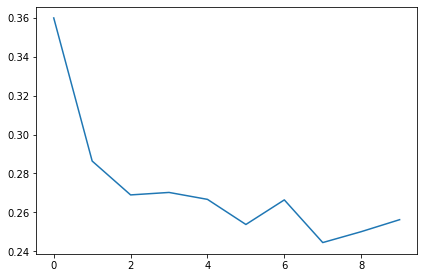

In [ ]:
plot_metrics(resampled_history)

In [ ]:
resampled_model = make_model()
resampled_model.load_weights(initial_weights)

# Reset the bias to zero, since this dataset is balanced.
output_layer = resampled_model.layers[-1] 
output_layer.bias.assign([0])

resampled_history = resampled_model.fit(
    resampled_ds,
    # These are not real epochs
    steps_per_epoch=20,
    epochs=10*EPOCHS,
    callbacks=[early_stopping],
    validation_data=(val_ds))

In [ ]:
train_predictions_resampled = resampled_model.predict(X_train, batch_size=BATCH_SIZE)
test_predictions_resampled = resampled_model.predict(X_test, batch_size=BATCH_SIZE)

loss :  0.28661438822746277
tp :  754.0
fp :  18399.0
tn :  180346.0
fn :  501.0
accuracy :  0.9054999947547913
precision :  0.039367202669382095
recall :  0.6007968187332153
auc :  0.8199458122253418
prc :  0.1666680872440338

Not Contacts Detected (True Negatives):  180346
Not Contacts Incorrectly Detected (False Positives):  18399
Contacts Missed (False Negatives):  501
Contacts Detected (True Positives):  754
Total Contacts:  1255


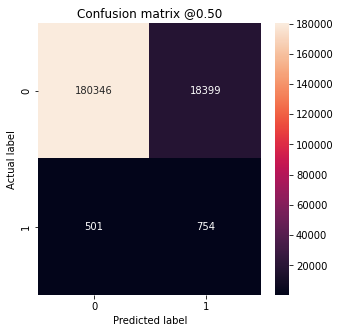

In [ ]:
resampled_results = resampled_model.evaluate(X_test, y_test,
                                             batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(resampled_model.metrics_names, resampled_results):
  print(name, ': ', value)
print()

plot_cm(y_test, test_predictions_resampled)

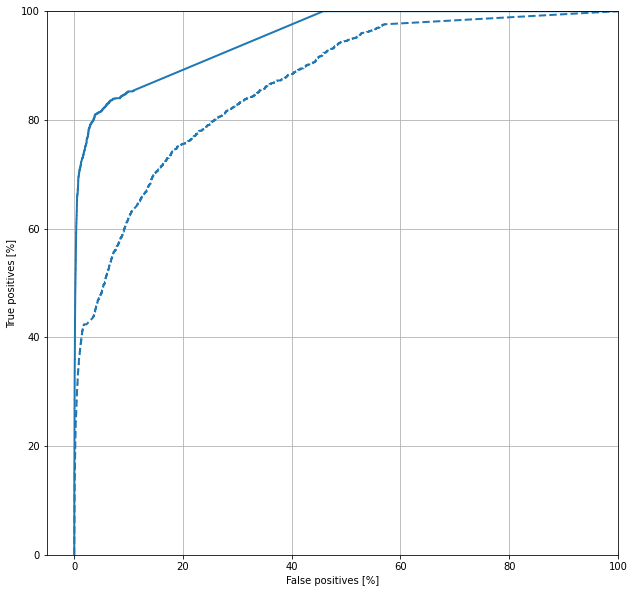

In [ ]:
plot_roc("Train Baseline", y_train, train_predictions_resampled, color=colors[0])
plot_roc("Test Baseline", y_test, test_predictions_resampled, color=colors[0], linestyle='--')

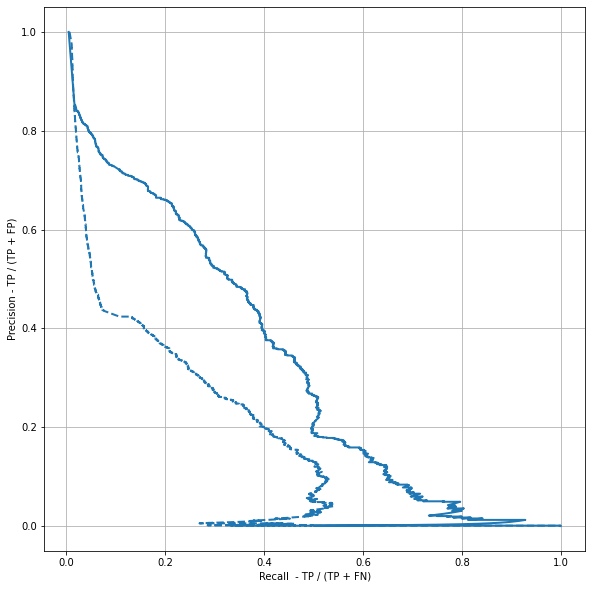

In [ ]:
plot_prc("Train Baseline", y_train, train_predictions_resampled, color=colors[0])
plot_prc("Test Baseline", y_test, test_predictions_resampled, color=colors[0], linestyle='--')